Iterations ENKF <class 'model1_class.Model1'>:   8%|▊         | 32/396 [00:04<00:37,  9.62it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: invalid value encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model1_class.Model1'>:  15%|█▌        | 61/396 [00:11<01:23,  4.00it/s]c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\agent1_class.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  self.g_rate = (self.wealth_list[-1] / self.wealth_list[-2]) - 1
Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 396/396 [00:41<00:00,  9.54it/s]
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model1_class.py:272: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'

this is total_wealth_ts [[ 1295860.80972495  1296394.67607258  1297197.12510994 ...
  19564045.2929327  19595206.37179411 19595806.85767068]
 [ 2111293.30623644  2136417.474668    2137898.41114476 ...
  11443549.04593528 11526493.88619848 11538961.24015652]
 [ 1084142.78798127  1084142.78798127  1088709.92400667 ...
  16949794.3566696  17006972.69981373 17032303.61654112]
 ...
 [ 5070576.15490373  5070576.15490373  5083539.69163422 ...
  18294876.41481517 18339477.64760647 18373777.00651187]
 [20007074.4480807  20093614.932911   20146171.74749253 ...
  16749227.6170065  16827724.19280833 16835590.0193979 ]
 [35639584.61919428 35706279.23992039 35823235.24118836 ...
  20973213.13582152 21155023.35252596 21155023.35252596]]
this is total_wealth_ts [[ 5739505.7825827   5747861.09093563  5765969.55581773 ...
  36682756.62665501 36734891.50859618 36778726.97758603]
 [ 9183465.90688447  9217087.95581494  9233748.4911785  ...
  31505711.31118426 31588656.15144746 31654317.54895977]
 [ 6481817

C:\Users\yoswald\AppData\Local\Temp\ipykernel_3492\339789845.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_3492\339789845.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


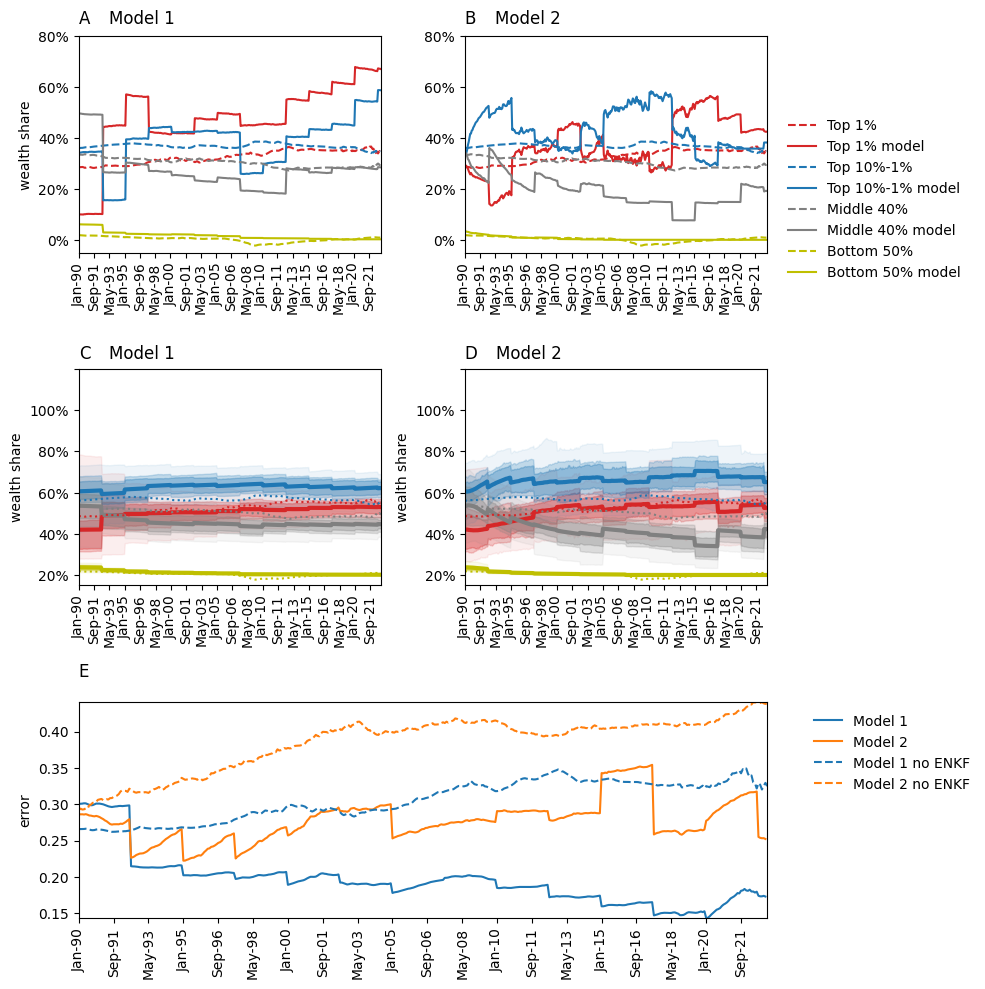

In [17]:
#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *
import import_ipynb
tqdm.pandas()

#%%


class Experiment1:
    def __init__(self, num_agents, ensemble_size, macro_state_dim, start_year, end_year, filter_freq):
        self.num_agents = num_agents
        self.ensemble_size = ensemble_size
        self.macro_state_dim = macro_state_dim
        self.enkf1 = None
        self.enkf2 = None
        self.start_year = start_year
        self.end_year = end_year

    def run_both_enkf(self, filter_freq):
        
        model_params1 = {"population_size": self.num_agents,
                        "growth_rate": 0.025,
                        "b_begin": 1.3,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "uncertainty_para": 0.1}
        
        model_params2 = {"population_size": self.num_agents, 
                        "concavity": 1,
                        "growth_rate": 0.025, 
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        
        self.enkf1 = prepare_enkf(Model1,
                                  model_params= model_params1,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        self.enkf2 = prepare_enkf(Model2,
                                   model_params= model_params2,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        run_enkf(self.enkf1, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)
        run_enkf(self.enkf2, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)

    def plot_results(self):

        fig = plt.figure(figsize=(10, 10))
        # Create a gridspec object
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        # Create individual subplots
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[0, 1])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[1, 1])
        ax4 = plt.subplot(gs[2, :])  # This one spans both columns

        
        self.enkf1.models[0].plot_wealth_groups_over_time(ax0, self.start_year, self.end_year)
        self.enkf2.models[0].plot_wealth_groups_over_time(ax1, self.start_year, self.end_year)
        self.enkf1.plot_fanchart(ax2)
        self.enkf2.plot_fanchart(ax3)        
        self.enkf1.plot_error(ax4)
        self.enkf2.plot_error(ax4)

        ###EXTRAS
        #AX0
        ax0.text(0, 0.85, 'A', fontsize = 12)
        ax0.text(40, 0.85, 'Model 1', fontsize = 12)
        #AX1
        ax1.legend(loc=(1.05, -0.15), frameon = False) ### legend only here
        ax1.text(0, 0.85, 'B', fontsize = 12)
        ax1.text(40, 0.85, 'Model 2', fontsize = 12)
        #AX2
        ax2.text(0, 1.05, 'C', fontsize = 12)
        ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax2.text(40,1.05, 'Model 1', fontsize = 12)
        #AX3
        ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax3.text(0,1.05, 'D', fontsize = 12)
        ax3.text(40,1.05, 'Model 2', fontsize = 12)

        path = '..'
        with open(os.path.join(path, 'data', 'mean_errors.csv')) as f:
            errors_df_no_enkf = pd.read_csv(f, encoding='unicode_escape')

        ax4.plot(errors_df_no_enkf['mean_error_model1'], linestyle='--', label='Model 1 no ENKF', color='tab:blue')
        ax4.plot(errors_df_no_enkf['mean_error_model2'], linestyle='--', label='Model 2 no ENKF', color='tab:orange')
        ax4.legend(bbox_to_anchor=(1.05, 1), frameon=False)
        
        # Get the limits
        x_min, x_max = ax4.get_xlim()
        y_min, y_max = ax4.get_ylim()
        ax4.text(0, y_max+0.02, 'E', fontsize = 12)
        ax4.margins(0)


        plt.tight_layout()
        plt.savefig('fig4.png', dpi=300)
        plt.show()
  
        
        
# Example usage
if __name__ == "__main__":
    filter_freq = 30
    experiment1 = Experiment1(num_agents=100, 
                              ensemble_size=100, 
                              macro_state_dim=4, 
                              start_year=1990,
                              end_year=2022,
                              filter_freq = filter_freq)
    experiment1.run_both_enkf(filter_freq = filter_freq)
    experiment1.plot_results()
    agent_states_model1 = experiment1.enkf1.micro_history
    agent_states_model2 = experiment1.enkf2.micro_history



## Plot agent-state variables and how the ENKF affects them

### Collect data from model 1

In [18]:
# Initialize an empty list to store the data
data = []
# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model1):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data.append(df)

# Concatenate the list into a single DataFrame
result_df = pd.concat(data, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df.columns = [f'ensemble_member_{i}' for i in range(result_df.shape[1] - 1)] + ['time_step']

print(result_df.head())


              0             1             2             3             4  \
0  1.396057e+06  2.367864e+06  1.157641e+06  2.868373e+06  1.968453e+06   
1  7.877821e+05  1.309391e+06  1.036146e+06  2.479189e+06  9.885584e+05   
2  5.930491e+05  1.207489e+06  9.044104e+05  2.250374e+06  7.522215e+05   
3  5.568638e+05  1.171535e+06  6.488484e+05  1.429170e+06  7.307751e+05   
4  5.533837e+05  9.115793e+05  6.191705e+05  1.213806e+06  6.507036e+05   

              5             6             7             8             9  ...  \
0  2.492771e+06  2.351231e+07  1.642875e+06  2.910871e+06  2.321068e+06  ...   
1  1.079063e+06  1.132422e+07  8.195634e+05  1.973851e+06  1.200458e+06  ...   
2  9.217947e+05  6.399632e+06  7.891168e+05  1.469815e+06  7.760180e+05  ...   
3  7.613167e+05  2.466386e+06  7.025761e+05  9.578849e+05  7.644150e+05  ...   
4  7.062484e+05  1.645405e+06  6.502765e+05  6.754302e+05  7.572373e+05  ...   

             91            92            93            94           

### Collect data from model 2

In [19]:
# Initialize an empty list to store the data
data_model2 = []

# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model2):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data_model2.append(df)

# Concatenate the list into a single DataFrame
result_df_model2 = pd.concat(data_model2, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df_model2.columns = [f'ensemble_member_{i}' for i in range(result_df_model2.shape[1] - 1)] + ['time_step']

print(result_df_model2.head())


              0             1             2             3             4  \
0  1.482005e+07  1.052281e+07  6.113932e+06  5.689466e+07  1.529279e+07   
1  7.923309e+06  8.876706e+06  4.006835e+06  1.589883e+07  8.357185e+06   
2  8.404044e+06  6.575590e+06  2.628247e+06  9.067320e+06  4.285096e+06   
3  4.154279e+06  6.278811e+06  2.092897e+06  4.776564e+06  2.954308e+06   
4  3.600437e+06  3.098762e+06  1.491368e+06  3.331210e+06  2.222919e+06   

              5             6             7             8             9  ...  \
0  1.234036e+07  1.320347e+07  3.684116e+06  8.335309e+06  1.126661e+07  ...   
1  5.693791e+06  4.669444e+06  2.523412e+06  7.434053e+06  3.965901e+06  ...   
2  4.799353e+06  4.486625e+06  2.469586e+06  5.614650e+06  2.766775e+06  ...   
3  2.276145e+06  2.671179e+06  1.767414e+06  3.603313e+06  2.315190e+06  ...   
4  2.020786e+06  2.049600e+06  1.687048e+06  2.754180e+06  1.972030e+06  ...   

             91            92            93            94           

## Try plotting average of ensembles evolution

C:\Users\yoswald\AppData\Local\Temp\ipykernel_3492\2693063589.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])
c:\Users\yoswald\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\yoswald\AppData\Local\Temp\ipykernel_3492\2693063589.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resu

Text(0.5, 1.0, 'Model 2')

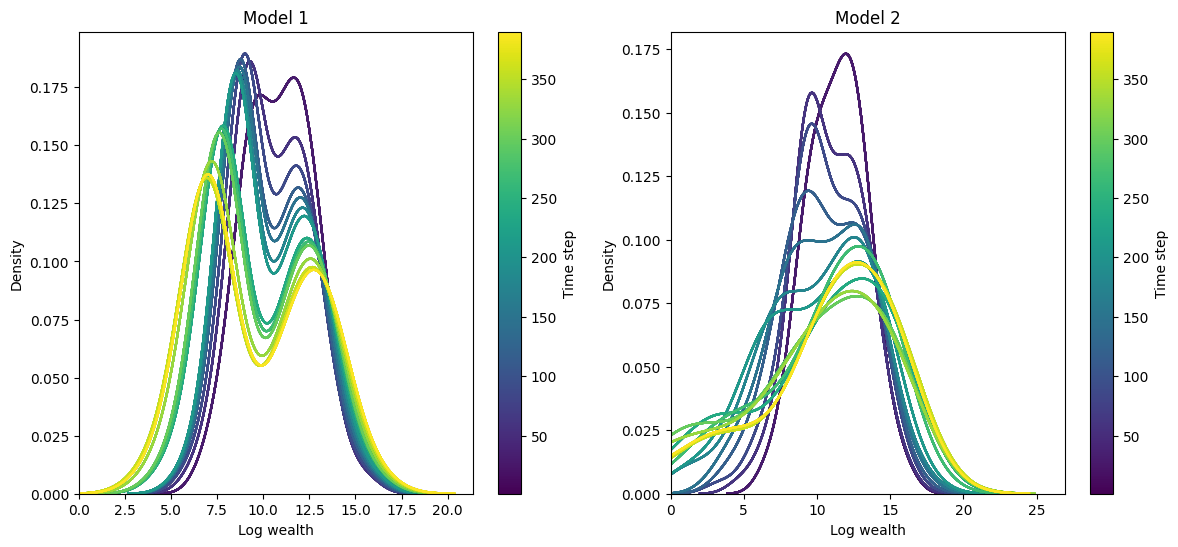

In [20]:

# import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# build average of all ensemble members
result_df['average_wealth'] = result_df.iloc[:, 1:-1].mean(axis=1)
result_df_avg = result_df[['time_step', 'average_wealth']]

# log transform the average data
result_df_avg['log_wealth'] = np.log(result_df_avg['average_wealth'])

# loop over time steps and plot all data as kernel density estimates with a colormap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)

for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg[result_df_avg['time_step'] == time_step]['log_wealth'], ax=ax1, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax1)
cbar.set_label('Time step')
ax1.set_xlabel('Log wealth')
ax1.set_ylabel('Density')
# set left x axis limit at 0
ax1.set_xlim(left=0)
ax1.set_title('Model 1')




## Model 2
# build average of all ensemble members
result_df_model2['average_wealth'] = result_df_model2.iloc[:, 1:-1].mean(axis=1)
result_df_avg_model2 = result_df_model2[['time_step', 'average_wealth']]
# log transform the average data
result_df_avg_model2['log_wealth'] = np.log(result_df_avg_model2['average_wealth'])

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=1, vmax=390)
for time_step in range(1, 390):
    color = cmap(norm(time_step))
    sns.kdeplot(result_df_avg_model2[result_df_avg_model2['time_step'] == time_step]['log_wealth'], ax=ax2, color=color, label=f'Time step {time_step}', alpha=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax2)
cbar.set_label('Time step')
ax2.set_xlabel('Log wealth')
ax2.set_ylabel('Density')
# set left x axis limit at 0
ax2.set_xlim(left=0)
ax2.set_title('Model 2')




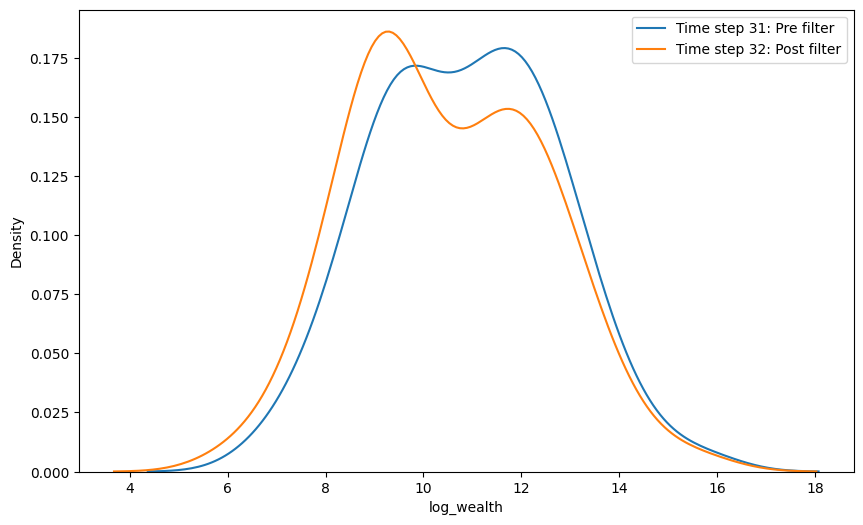

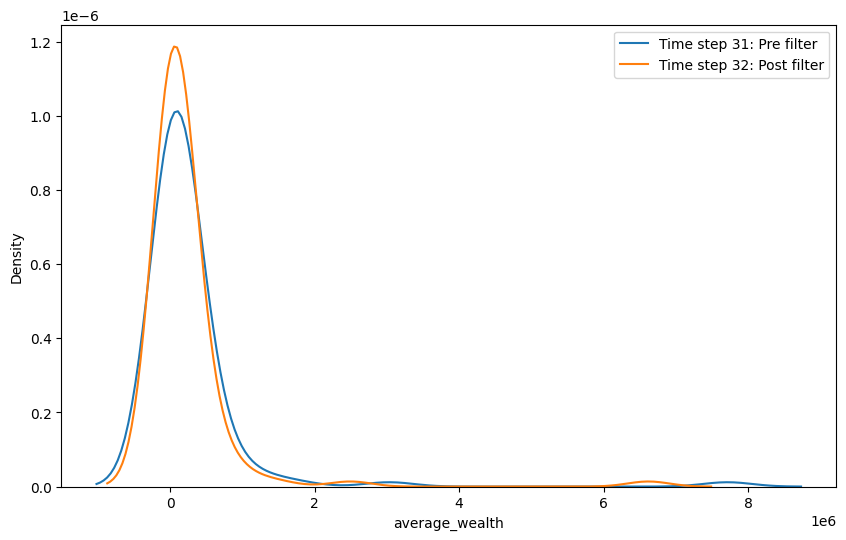

In [21]:
### plot time step 20 and 40 kernel density estimates of the log values
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 31]['log_wealth'], ax=ax, label='Time step 31: Pre filter', color='tab:blue')
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 32]['log_wealth'], ax=ax, label='Time step 32: Post filter', color='tab:orange')
# add a legend
ax.legend()

# for the same time steps plot non log values
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 31]['average_wealth'], ax=ax, label='Time step 31: Pre filter', color='tab:blue')
sns.kdeplot(result_df_avg[result_df_avg['time_step'] == 32]['average_wealth'], ax=ax, label='Time step 32: Post filter', color='tab:orange')
ax.legend()

